# Capstone 1:  Exercise 10.6.1:  Part II:  v3

# Random forest regression on Ames Housing Data

I am continuing my work to predict the sales prices of residential homes from the Ames housing data set.  In this notebook, I will explore random forest regression and see if it beats my best prior linear regression model.

Here's my approach to random forest regression

* Reuse my prior cleaning, test splits, etc
* Score a plain-vanilla baseline model
* Tune key parameters for a best model
* Tune off feature importance
* Compare results of random feature models after parameter and feature tuning
* Compare the best random forest model to my best linear regression model

I will evaluate my random forest models with:

* OOB:  This is an accuracy score using the out of bag samples and is comparable to R2 for linear models
* RMSE:  This is the standard standard deviation of predicted v. observed and is more sensitive to outliers
* MAE:  This is the mean of the absolute difference of predicted v. observed and is less sensitive to outliers
* R2:  This indicates how well my predictors are explaining my target

#### History

* v1:  Wrote baseline notebook 
* v2:  Removed comparisons to training set.  Discussed how different params might have impacted results.  Moved the tuning estimators using OOB to appendix.  Created a prediction interval.  Compared prediction intervals across linear and rf.
* v3:  Fixed some typos.

## Get ready

### Set up

In [1]:
# Import basic libraries, set some defaults

import numpy as np
from numpy.random import seed
from numpy.random import randint

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')

import seaborn as sns

In [2]:
# Import from scikit learn

# Import from tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Import models
from sklearn.ensemble import RandomForestRegressor

# Import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Load data

In [3]:
# Load the ready-for-ML data from my last notebook

df_X = pd.read_pickle("../sb_cap1_data/df_X_prepped.pickle")
df_y = pd.read_pickle("../sb_cap1_data/df_y_prepped.pickle")

# # Check
# df_X.head()
# df_y.head()

### Build scoring function

In [4]:
# Stand up a dataframe for my results
results_df = pd.DataFrame(columns=['model', 'y_set', 'r2', 'mse', 'rmse', 'mae', 'oob'])

# Note that I also need to clear the dataframe when I debug and rerun the notebook
results_df.drop(results_df.index, inplace=True)

# # Check
# results_df

In [5]:
# Create a scoring function
def score_model(results_ptr, model_str, y_comp_ptr, y_comp_str, model_ptr):
    
    # Point to the correct model and get name a string
    results = results_ptr
    results_str = model_str

    # Point to the correct result set and get name a string
    y_comp = y_comp_ptr
    y_comp_str = y_comp_str

    ## Point to the model
    model = model_ptr

    # Built the results list
    results_list = [results_str, y_comp_str]

    # Calc r-squared
    results_r2 = r2_score(y_comp, results)
    results_list.append(results_r2)

    # Calc MSE
    results_mse = mean_squared_error(y_comp, results)
    results_list.append(results_mse)

    # Calc RMSE
    results_rmse = np.sqrt(results_mse)
    results_list.append(results_rmse)

    # Calc MAE
    results_mae = mean_absolute_error(y_comp, results)
    results_list.append(results_mae)

    # Calc OOB
    if model.oob_score:
        results_oob = model.oob_score_
    else:
        results_oob = None
    results_list.append(results_oob)

    # Add to master dataframe
    results_df.loc[len(results_df)] = results_list

    return

###  Split data with same split from linear modeling

In [6]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42)

## Build baseline model

I will start with a most-basic random forest regressor.  

In fact, I will use only two non-default parameters.

* I will turn on bootstrapping in order to generate an out-of-bag score.
* I will change the n_estimators to 1 above the mininum default of 20 to disable an annoying warning.

In [7]:
# Instantiate the model
rf_bse = RandomForestRegressor(bootstrap=True,
                               n_estimators = 21, 
                               oob_score=True,
                               random_state = 42)

# Train the model
rf_bse.fit(X_train, y_train.values.ravel())

# NOTE:  I add to add '.value.ravel()' to end of labels_train to eliminate a warning

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=21,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [8]:
# Predict
rf_bse_pred_test = rf_bse.predict(X_test)

In [9]:
# Score
score_model(rf_bse_pred_test, 'rf_bse_pred_test', y_test, 'y_test', rf_bse)

In [10]:
## Look at results table
results_df[results_df['model'].str.contains('rf_bse_pred')] 

,model,y_set,r2,mse,rmse,mae,oob
0,rf_bse_pred_test,y_test,0.835236,0.026399,0.162477,0.11504,0.802986


**Takeaways:** 

The baseline model has good performance

* With OOB at 80%, it's decently accurate on out-of-bag samples
* MAE is about .1, and RMSE is about .16, which doesn't seem too bad. And it's not surprising that RMSE is higher than MAE as the data has outliers at higher prices
* With R2 at 83%, it's got good explanatory power

## Tune parameters

Let's see if I can improve performance and reduce errors by tuning some parameters.

Also, I'm going to tune in steps, not all at once.  Here's why.  When I first set up my grid search across my top-of-mind parameters, I got terrible computer performance.  Even after 30 minutes of compute, the notebook was still spinning.  With a bit of trial and error, I realized that tuning off the number of estimators consumed the most CPU cycles.

So, now I'm going to:

* First, tune the number of estimators
* Second, tune all remaining parameters

Also, I'm going to comment out some of the tuning code after it successfully completes.  This will allow me to grow (and debug!) this notebook more quickly.

### Tune on number of estimators

In [11]:
# # Instantiate the model
# rf_tune_1 = RandomForestRegressor(random_state = 42)

# # Set up my grid of parameters

# parameters = {'n_estimators': [10, 100, 1000, 10000]}

# # Instantiate the gridsearch
# rf_cv = GridSearchCV(rf_tune_1, parameters, cv=5)

# # Fit the gridsearch to the test data
# rf_cv.fit(X_train, y_train.values.ravel())

# # Print results
# print('The best parameters are {}'.format(rf_cv.best_params_))
# print('The best score is {}'.format(rf_cv.best_score_))

**Takeaways:**
    
Here are the results I got:

* The best parameters are {'n_estimators': 10000}
* The best score is 0.8249320882060633


This leads me to conclude:

* This model does better with more estimators.
* But I'm looking for a compromise between score and performance
* So, rather than 10,000 estimators, I'm going to use 1,000 in my best model

### Tune on other parameters

In [12]:
# # Instantiate the model
# rf_tune = RandomForestRegressor(n_estimators=150,
#                                 random_state = 42)

# # Set up my grid of parameters
# parameters = {'bootstrap': [True, False],
#               'max_depth': [2, 25, 50],
#               'min_samples_leaf': [2, 3, 4],
#               'max_features' : ['log2', 'sqrt', 8, 10, 15],
#               'min_samples_split': [2, 3, 4]
#              }

# # Instantiate the gridsearch
# rf_cv = GridSearchCV(rf_tune, parameters, cv=5)

# # Fit the gridsearch to the test data
# rf_cv.fit(X_train, y_train.values.ravel())

# # Print results
# print('The best parameters are {}'.format(rf_cv.best_params_))
# print('The best score is {}'.format(rf_cv.best_score_))

**Takeaways:**

Here are the results:

* The best parameters are {'bootstrap': False, 'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
* The best score is 0.8424799308498343

This leads me to conclude:

* I'll use most of these parameters in my best model.
* It's interesting that bootstrapping costs some performance.  Aka, bootstrap=False is part of the best-performing model in this grid search.  Stil, I want to use oob_score to evaluate performance

### Define best model

In [13]:
# Set parameters for by best model
BS = True
NE = 1000
MD = 25
MF = 10
MSL = 2
MSS = 2
OS = True
RS = 42

**Takeways:**

To define my best model, I'm using:

* bootrapping
* 1,000 estimators (as a compromise on performance)
* All the other best performing features

Here's what I am thinking about those features:

* bootstrapping:  We're giving up a bit of model performance for easier model 'management' (aka, the ability to have a score that I know and understand)
* number of estimators:  I'm a bit surprised that more trees is better performance.  I'd have thought that all 'information' in the trees caps out after some high-number of trees.
* max depth:  I was expecting more stump-like trees.  So, 25 seemed rather deep to me.  But maybe not give there are only 10 features.
* max features:  I was surprised here that the answer was not 'the basic rule' of square root of total features.  And the recommended number at 2x that.
* min leaf size:  This isn't surprising as it's as small as I permitted.
* min sample split:  Same as min leaf size

## Create best model

In [14]:
# Instantiate the model
rf_best = RandomForestRegressor(bootstrap=BS, 
                                max_depth=MD, 
                                max_features=MF, 
                                min_samples_leaf=MSL, 
                                min_samples_split=MSS, 
                                n_estimators=NE,
                                oob_score=OS,
                                random_state=RS)

# Train the model
rf_best.fit(X_train, y_train.values.ravel())                                                                                                                                       

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [15]:
# Predict
rf_best_pred_test = rf_best.predict(X_test)

# Score
score_model(rf_best_pred_test, 'rf_best_pred_test', y_test, 'y_test', rf_best)

# # Check
# results_df

## Compare baseline and best

In [16]:
# Look at results
results_df

,model,y_set,r2,mse,rmse,mae,oob
0,rf_bse_pred_test,y_test,0.835236,0.026399,0.162477,0.115040,0.802986
1,rf_best_pred_test,y_test,0.851354,0.023816,0.154326,0.108397,0.835432


**Takeaways:**

The best model (aka, the model after my tuning above) is better than the baseline model

* It's OOB score is 3% higher, at about 83%.
* It's got lower error--with a smaller RMSE.
* It's got more explanatory power--with higher R2 of about 2% more.
* This isn't all that surprising; tuning made a difference!

### Think about why these parameters might have impacted performance

In [17]:
# List parameters of my baseline and tuned model
rf_bse_params = rf_bse.get_params()
rf_best_params = rf_best.get_params()
params_df = pd.DataFrame([rf_bse_params, rf_best_params], index=['rf_bse', 'rf_best'])
params_df.transpose()

,rf_bse,rf_best
bootstrap,True,True
criterion,mse,mse
max_depth,NaN,25
max_features,auto,10
max_leaf_nodes,None,None
min_impurity_decrease,0,0
min_impurity_split,None,None
min_samples_leaf,1,2
min_samples_split,2,2
min_weight_fraction_leaf,0,0


**Takeaways:**

Here's my take on why the best parameters might have resulted in the improved performance.

* The number of estimators went way up.  From about 20 to 10,000 (aka, 500x).  With a lot more trees, we're ensembling a whole different magnitude of information.
* The number of features when down. From about 40 to 10 (aka, 1/4th).  We added (and gained from) all that variability in our trees.
* The depth of trees and the size of leaves when down.  From unlimited depth and 1-sample leaf.  To 25-level depth and 2-sample leaves.  Our best model used more simplified trees.

As I see, I magnified the 'wisdom of the crowds' aspect of this ensemble.  

* I sampled a much bigger crowd (aka, estimators)
* I ensured that they were 'less expert' (aka, constrained the three complexity)
* (Which is where random forests get their strength's from)

## Assess feature importance

### Inspect feature importance scores

In [18]:
# Create a dataframe of feature importance
feat_df = pd.DataFrame(rf_best.feature_importances_, 
                       columns = ['importance'],
                       index = X_train.columns
                      )
feat_df.sort_values(by='importance', ascending=False, inplace=True)

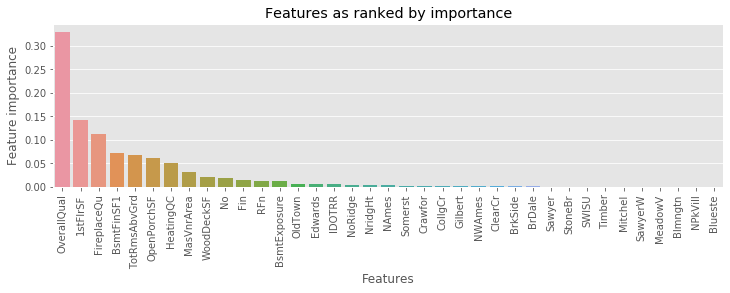

In [19]:
# Graph feature importance
g = plt.figure(figsize=(12, 3))
g = sns.barplot(x=feat_df.index, y=feat_df['importance'])
g = plt.xlabel("Features")
g = plt.xticks(rotation=90)
g = plt.ylabel('Feature importance')
g = plt.title('Features as ranked by importance')

In [20]:
# # Look at bins with cut
# pd.cut(feat_df['importance'], bins=4).value_counts()

### Sort features by importance

In [21]:
# Adding some categories from eyeballing the graph
feat_df['category'] = 'very_low'
feat_df.category[feat_df['importance'] >= .001] = 'low'
feat_df.category[feat_df['importance'] >= .05] = 'med'
feat_df.category[feat_df['importance'] >= .1] = 'hi'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [22]:
# Look at the table of scores
feat_df

,importance,category
OverallQual,0.329905,hi
1stFlrSF,0.141266,hi
FireplaceQu,0.112255,hi
BsmtFinSF1,0.072241,med
TotRmsAbvGrd,0.068544,med
OpenPorchSF,0.061950,med
HeatingQC,0.050300,med
MasVnrArea,0.032433,low
WoodDeckSF,0.021569,low
No,0.018195,low


**Takeways:**

Here's how I sort the features:

* A group of high-importance features.  The 3 above .1
* A group of medium-importance features.  The 4 above .05
* A group of low-importance features.  Those above .001
* Some very-low-importance features.  Those remaining features.

### Interpret feature importance

My high- and medium- importance features--aka, the top 7 features--are pretty much the same non-categorical features identified in my earlier analysis.

* These features are 7 of the 9 non-categorical feature that I used in the analysis.
* These features are ordered in almost the same order as their ranking by univariate R2.
* (But they have a different order than when I looked at their Lasso coefficient).

The low-importance feature are mostly the enumerated types from my non-categorical variables.

* Of the 20 low-importance features, 
* Most (14) are specific neighborhoods, presumably those which led to the most information gain
* Some (4) are categories of garage finish--the other categorical variable. 
* Again, the random forest's importance measures don't see to match the ranking by the Lasso model's coefficient.

The 10 very-low important features are all of the same type.

* All are one-hot-encoded neighborhoods.
* Presumably, they all lack a lot of unique information that contributes to price.


## Score best model with different sets of features

Here I will score the best random forest model when using different sets of features.  I will compare a model trained on:

* Only high-importance features.
* Only high- and medium-importance features
* Only high-, medium- and low-importance features (but not very-low importance features)
* All features (which has already been done above)

Note:  I bet there's a sklearn pipelines way to better automate this.

### Split up different combinations

In [23]:
# Make lists of features by category
feat_hi_ls = feat_df[feat_df['category'] == 'hi'].index.to_list()
feat_med_ls = feat_df[feat_df['category'] == 'med'].index.to_list()
feat_low_ls = feat_df[feat_df['category'] == 'low'].index.to_list()
feat_vlow_ls = feat_df[feat_df['category'] == 'very_low'].index.to_list()

# # Check
# print(feat_hi_ls)
# print(feat_med_ls)
# print(feat_low_ls)
# print(feat_vlow_ls)

# Create training sets with only high features by dropping med, low and very low
drop_ls = []
drop_ls = feat_med_ls + feat_low_ls + feat_vlow_ls
X_train_h = X_train.copy()
X_train_h.drop(drop_ls, axis=1, inplace=True)
X_test_h = X_test.copy()
X_test_h.drop(drop_ls, axis=1, inplace=True)

# # Check
# print(X_train_h.columns)
# print(X_test_h.columns)

# Create training sets with high + medium features by dropping low and very low
drop_ls = []
drop_ls = feat_low_ls + feat_vlow_ls
X_train_hm = X_train.copy()
X_train_hm.drop(drop_ls, axis=1, inplace=True)
X_test_hm = X_test.copy()
X_test_hm.drop(drop_ls, axis=1, inplace=True)

# # Check
# print(X_train_hm.columns)
# print(X_test_hm.columns)

# Create training sets with high + medium + low features by dropping very low
drop_ls = []
drop_ls = feat_vlow_ls
X_train_hml = X_train.copy()
X_train_hml.drop(drop_ls, axis=1, inplace=True)
X_test_hml = X_test.copy()
X_test_hml.drop(drop_ls, axis=1, inplace=True)

# # Check
# print(X_train_hml.columns)
# print(X_test_hml.columns)

### Score high-importance features only

In [24]:
# Get create, fit, score model

# Instantiate the model
rf_best_h = RandomForestRegressor(bootstrap=BS, 
                                max_depth=MD, 
                                max_features=None, 
                                min_samples_leaf=MSL, 
                                min_samples_split=MSS, 
                                n_estimators=NE,
                                oob_score=OS,
                                random_state=RS)

# NOTE:  I chnaged max features to none (aka, total number of features)
# as I've got less than 10 features

# Train the model
rf_best_h.fit(X_train_h, y_train.values.ravel())  

# Predict with test
rf_best_h_pred_test = rf_best_h.predict(X_test_h)

# Score off test
score_model(rf_best_h_pred_test, 'rf_best_h_pred_test', y_test, 'y_test', rf_best_h)

# # Check
# results_df

### Sore high and medium-importance features

In [25]:
# Get create, fit, score model

# Instantiate the model
rf_best_hm = RandomForestRegressor(bootstrap=BS, 
                                max_depth=MD, 
                                max_features=None, 
                                min_samples_leaf=MSL, 
                                min_samples_split=MSS, 
                                n_estimators=NE,
                                oob_score=OS,
                                random_state=RS)

# NOTE:  I chnaged max features to none (aka, total number of features)
# as I've got less than 10 features

# Train the model
rf_best_hm.fit(X_train_hm, y_train.values.ravel()) 
# Predict with test
rf_best_hm_pred_test = rf_best_hm.predict(X_test_hm)

# Score off test
score_model(rf_best_hm_pred_test, 'rf_best_hm_pred_test', y_test, 'y_test', rf_best_hm)

# # Check
# results_df

### Score high-, medium- and low-importance features

In [26]:
# Get create, fit, score model with hi, med- and low- improtance fatures

# Instantiate the model
rf_best_hml = RandomForestRegressor(bootstrap=BS, 
                                max_depth=MD, 
                                max_features=MF, 
                                min_samples_leaf=MSL, 
                                min_samples_split=MSS, 
                                n_estimators=NE,
                                oob_score=OS,
                                random_state=RS)

# NOTE:  I added back max_features=10
# as I've got more than 10 features in total

# Train the model
rf_best_hml.fit(X_train_hml, y_train.values.ravel())

# Predict with test
rf_best_hml_pred_test = rf_best_hml.predict(X_test_hml)

# Score off test
score_model(rf_best_hml_pred_test, 'rf_best_hml_pred_test', y_test, 'y_test', rf_best_hml)

# # Check
# results_df

### Evaluate

In [27]:
# Look at relevant part of results table
results_df[~results_df['model'].str.contains('rf_bse_pred')].sort_values(by='oob', ascending=False)
# results_df[~results_df['model'].str.contains('rf_bse_pred')].sort_values(by='rmse', ascending=True)
# results_df[~results_df['model'].str.contains('rf_bse_pred')].sort_values(by='r2', ascending=False)
# results_df[~results_df['model'].str.contains('rf_bse_pred')]

,model,y_set,r2,mse,rmse,mae,oob
1,rf_best_pred_test,y_test,0.851354,0.023816,0.154326,0.108397,0.835432
4,rf_best_hml_pred_test,y_test,0.852903,0.023568,0.153519,0.107865,0.834815
3,rf_best_hm_pred_test,y_test,0.824770,0.028076,0.167558,0.120342,0.800570
2,rf_best_h_pred_test,y_test,0.781045,0.035081,0.187300,0.138964,0.696062


**Takeaways:**

Here's how I read the results:

* The models with all features and with high-medium-low-importance features are better than the models with only high importance features and only high-and-medium-importance features.
* The model with all features has the highest OOB score, followed closely by the model with high-medium-low features.
* The model with high-medium-low features has the lowest RMSE and MAE, followed closely by the model with all features.
* The model with high-medium-low features has the most explanatory power (R2), followed closely by the  model with all-features.

I conclude that the best model is my model with high-medium-low-importance features.  

* Basically, I'm trading a small loss on OOB score for small gain on accuracy and explanatory power, as compared to the model with all features.

#### Bottom line, I'm recommending my "rf_best_hml" model

## Calc a prediction interval with best_hml model

I want to use this model to help clients predict sales price.  To do this, I will predict a value and create a prediction interval.  I will use the same observation that I randomly picked when doing the same exercise for the linear model.

In [28]:
# Assign the index number of the observation randomly chosen in last notebook
TEST_RAND = 215

# # Check
# X_test.iloc[TEST_RAND]

In [29]:
# Get predicted price
this_rf_best_hml_pred_test = rf_best_hml_pred_test[TEST_RAND]

# # Check
# this_rf_best_hml_pred_test

In [30]:
# Get the actual sales price
this_actual = y_test.iloc[TEST_RAND]

In [31]:
# Get residuals
resid = rf_best_hml_pred_test - y_test.values.ravel()

# # Check
# resid

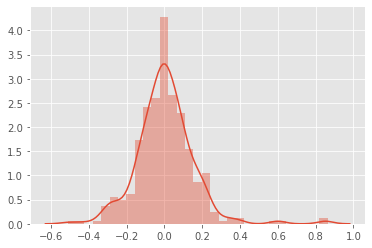

In [32]:
# Visualze the residuals
sns.distplot(resid)
plt.show()

In [33]:
# Get quantiles
lower_ci_quant = np.quantile(resid, 0.025)
upper_ci_quant = np.quantile(resid, 0.975)

# Convert to absolute values
lower_ci = np.absolute(lower_ci_quant)
upper_ci = np.absolute(upper_ci_quant)

# # Check
# print(lower_ci)
# print(upper_ci)

# Calc interval
lower_a1 = this_rf_best_hml_pred_test - lower_ci
upper_a1 = this_rf_best_hml_pred_test + upper_ci

# # Check
# print(lower_a1)
# print(upper_a1)

In [34]:
# Create dataframe with this prediction interval
interpret_dict_1 = {'model': 'rf_best_hml',
                    'y_test_iloc': [TEST_RAND],
                  'pred_log_lower_ci': [lower_a1],
                  'pred_log': [this_rf_best_hml_pred_test],
                  'pred_log_upper_ci': [upper_a1],
                  'pred_dollar_lower': [np.exp(lower_a1)],
                  'pred_dollar': [np.exp(this_rf_best_hml_pred_test)],
                  'pred_dollar_upper': [np.exp(upper_a1)],
                  'actual_log': [this_actual[0]],
                  'actual_dollar': [np.exp(this_actual[0])]
                 }
interpret_df_1 = pd.DataFrame(interpret_dict_1)

# # Check
# interpret_dict_1
# interpret_df_1

In [35]:
# Print values
print('The predicted price written as a natural log is {:.3f}'.format(this_rf_best_hml_pred_test))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(lower_a1, upper_a1))
print('And the actual sales price as a natural log was {}'.format(this_actual[0]))
print()
print('The predicted price in dollars is {:}'.format(np.exp(this_rf_best_hml_pred_test)))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(np.exp(lower_a1), np.exp(upper_a1)))
print('And the actual sales price was {}'.format(np.exp(this_actual[0])))

The predicted price written as a natural log is 11.689
With a 95% confidence interval between 11.402 and 11.968
And the actual sales price as a natural log was 11.76756768334381

The predicted price in dollars is 119227.10683613854
With a 95% confidence interval between 89496.411 and 157640.641
And the actual sales price was 129000.00000000006


**Takeaways:**

In this example, our model predicted:

* A value of about \\$120,0000 (which turned about to be within about \\$10,000 of the sales price).
* A 95% confidence interval that ranged from about \\$90,000 to \\$160,000.

## Compare linear regression and random forest regression

### Make dataframe with performance values from two models

In [36]:
# Make a dataframe to compare final rf model and final lr model
results_rf_final = results_df[results_df['model'].str.contains('rf_best_hml_pred')].copy()

# # Check
# results_rf_final

In [37]:
# Load the results of my linear model
results_lr_final = pd.read_pickle("../sb_cap1_data/results_lr.pickle")

# Drop the training results
results_lr_final.drop(0, axis=0, inplace=True)

# # Check
# results_lr_final

In [38]:
# Concat the two data frames
results_final = pd.concat([results_lr_final, results_rf_final])

# # Check
# results_final

In [39]:
# Calc differences
results_diff_ls = ['difference_lin_minus_rf', 'None']
for i in range(2, 6):
    results_diff = results_final.iloc[0, i] - results_final.iloc[1, i]
    results_diff_ls.append(results_diff)
results_diff_ls.append('None')
# results_diff_ls

# Add as last row to dataframe
results_row = len(results_final)
results_final.loc[99] = results_diff_ls

# Check
# results_final

### Compare performance results of two models

In [40]:
# Look at label of results
results_final

# # Look at sorted lists
# results_final.sort_values(by='r2', ascending=False)
# results_final.sort_values(by='rmse', ascending=True)
# results_final.sort_values(by='mae', ascending=True)

,model,y_set,r2,mse,rmse,mae,oob
1,lin_norm_test,y_test,0.857840,0.022777,0.150921,0.109485,None
4,rf_best_hml_pred_test,y_test,0.852903,0.023568,0.153519,0.107865,0.834815
99,difference_lin_minus_rf,None,0.004937,-0.000791,-0.002598,0.001621,None


**Takeaways:**

Here's what I see in the results:

* There's no direct comparison for OOB.
* The models are split on their errors.  Random forest (rf) has a bit better RMSE.  Linear regression (lin) has a bit better MAE.
* Lin is a bit petter on R2.

I conclude that linear regression is my best model for the bit of improvement on R2.

### Make dataframe with prediction intervals from two models

In [41]:
# Rename dataframe with predicted values
pred_example_rf_df = interpret_df_1

# # Check
# pred_example_rf_df

In [42]:
# Load the prediction example from the linear model
pred_example_lin_df = pd.read_pickle("../sb_cap1_data/pred_example_lin_df")

# # Check
# pred_example_lin_df

In [43]:
# Concat the two data frames
pred_example_df = pd.concat([pred_example_rf_df, pred_example_lin_df])

# # Check
# pred_example_df

In [44]:
# Calc differences between random forest adn linear
pred_example_ls = ['diff_rf_minus_lin', '']
for i in range(2, 8):
    pred_example = pred_example_df.iloc[0, i] - pred_example_df.iloc[1, i]
    pred_example_ls.append(pred_example)
pred_example_ls.append('')
pred_example_ls.append('')

# # Check
# pred_example_ls

# Add as last row to dataframe
pred_example_row = len(pred_example_df)
pred_example_df.loc[99] = pred_example_ls

### Compare prediction intervals from two models

In [45]:
# Print dataframe with prediction intervals
pred_example_df

,model,y_test_iloc,pred_log_lower_ci,pred_log,pred_log_upper_ci,pred_dollar_lower,pred_dollar,pred_dollar_upper,actual_log,actual_dollar
0,rf_best_hml,215,11.401954,11.688785,11.968073,89496.410570,119227.106836,157640.641244,11.7676,129000
0,lin_norm,215,11.466699,11.725088,12.038726,95482.579935,123634.903490,169181.279259,11.7676,129000
99,diff_rf_minus_lin,,-0.064745,-0.036303,-0.070653,-5986.169365,-4407.796653,-11540.638015,,


**Takeaways:**

The two models don't give the same prediction.  

* There's a difference of about \\$5,000 or 4\% between the two prediction.
* The linear model's prediction is a bit closer to the actual value.

The two models don't have the same prediction intervals.

* The linear model's interval is wider.
* The range of the linear model interval is:  \\$74,000.
* The range of the random forest's interval is  about \\$68,000.

In this specific case, neither prediction seems particularly stronger.

Most importantly, this exercise of comparing one individual prediction from each model isn't all that informative.  Mainly, it's for a bit of context.

# Appendices

## A:  Explore max features and estimators using OOB error

In this appendix, I'm going to look at how different settings for max_features parameter and n_estimators impact OOB error.

Note that this appendix is looking at a different score than that used in the grid search above.

* In the section above, I used the GridSearchCV's default accuracy score.  As in the case of all regression models, this is R2.
* In this appendix, I'm using OOB error.

Also, for this section, I'm following the example in "OOB Errors for Random Forests" in sklearn docs.

### A1:  Collect OOB score for different max features across different number of estimators 

In [46]:
# Import a data structure
from collections import OrderedDict

# Set random state
RANDOM_STATE = 42

# Generate a binary classification dataset.
X, y = X_train, y_train.values.ravel()

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("max_features='log2'",
        RandomForestRegressor(warm_start=True, 
                              bootstrap=True,
                              max_features='log2',
                              oob_score=True,
                              random_state=RANDOM_STATE)),
    ("max_features='sqrt'",
        RandomForestRegressor(warm_start=True, 
                              bootstrap=True,
                              oob_score=True,
                              max_features="sqrt",
                              random_state=RANDOM_STATE)),
    ("max_features='10'",
        RandomForestRegressor(bootstrap=True,
                              max_features=10,
                              oob_score=True,
                              random_state=RANDOM_STATE,
                              warm_start=True)),
    ("max_features='None'",
        RandomForestRegressor(warm_start=True,
                              bootstrap=True,
                              max_features=None,
                              oob_score=True,
                              random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 21
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

### A2:  Visualize results

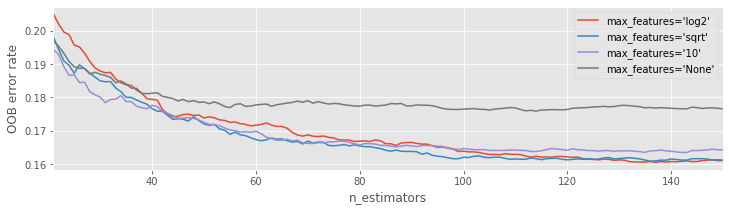

In [47]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
_ = plt.figure(figsize=(12, 3))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    _ = plt.plot(xs, ys, label=label)
_ = plt.xlim(min_estimators, max_estimators)
_ = plt.xlabel("n_estimators")
_ = plt.ylabel("OOB error rate")
_ = plt.legend(loc="upper right")
plt.show()

### A3:  Conclude

In [48]:
# Get a sense of key values
z = len(X_train.columns.to_list())
print('The max number of features is {}'.format(z))
print('The sqrt of number of features is {}'.format(np.sqrt(z)))
print('The log2 of number of features is {}'.format(np.log2(z)))

The max number of features is 37
The sqrt of number of features is 6.082762530298219
The log2 of number of features is 5.20945336562895


**Takeaways:**

This graphs shows oob error going down as the number of estimators goes up when there a limit on the number of features.  In the case of no limit on max features, the OOB error rate is higher and seems to flatten out.

The results don't quite reconcile with my tuning via grid search.

* Grid search is saying the accuracy score (aka, R2) is better with 10 features at 150 estimators.
* This is saying that that OOB score is better (aka, error is less) with about 5 features (aka, sqrt) at 150 estimators.

But this is consistent with the fact that R2 hasn't been the same as OOB throughout out my testing.

## B: Visualize a single tree

I wanted to look at an example tree.  So, I found an example in a blog and got it working.  

But after further expanding my main analysis, the example below stopped working.  

* I assume the problem has to do with versioning of the visualization package--pydot v. pydotplus.
* Plus this intersects with my python package management.  Aka, some are loaded by conda, some by pip.
* Since I'd saved my results, I got what I wanted out of this appendix.  
* And I don't see much value in solving the installation problems.  
* In the future, I'll have to get a handle on conda environments so I can easily add (and roll back) different imports

Bottom line, I'll keep my (buggy) code in place and link to my visualizations.

In [49]:
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydotplus

In [50]:
# # Point towards a model
# this_model = rf_best
# this_model_feat_name = X_train.columns

# # Get one of this model's 1000 estimators at random
# seed(42)
# est_rand = randint(0, 999, 1)[0]

# # # Check
# # est_rand

In [51]:
# # Pull out one tree from the forest
# tree = this_model.estimators_[est_rand]

# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree_all.dot', 
#                 feature_names = this_model_feat_name, 
#                 rounded = True, 
#                 precision = 1
#                )

# # Use dot file to create a graph
# (graph, ) = pydotplus.graph_from_dot_file('tree_all.dot')

# # Write graph to a png file
# graph.write_png('../sb_cap1_data/tree_all.png')

A full image of one tree is located in my 'data' folder as 'tree_all.png'.

Here's a link to the image, which is displaying successfully on my local notebook, but not in github:

![Full image of one tree](./data/tree_all.png)

A close up of the first few nodes on that tree is located in my 'data' folder as 'tree_all_close-up.png'.

Here's a link to the image, which is displaying successfully on my local notebook, but not in github:

![Close up of top of earlier tree](./data/tree_all_close-up.png)

## C: Confirm that OOB score depends on boostrap = True

I don't see anything in the sk-learn documents that says I need boostrap = True to get an OOB score.

But to confirm this, I will run a model with 

* boostrap=False
* oob_score=True

Does it work?

In [52]:
# # Instantiate the model
# rf_bse_append = RandomForestRegressor(bootstrap=False,
#                                n_estimators = 21, 
#                                oob_score=True,
#                                random_state = 42)

# # Train the model
# rf_bse_append.fit(X_train, y_train.values.ravel())


# # Predict
# rf_bse_append_pred_test = rf_bse.predict(X_test)


# # Score
# score_model(rf_bse_append_pred_test, 'rf_bse_append_pred_test', y_test, 'y_test', rf_bse_append)

# ## Look at results table
# results_df[results_df['model'].str.contains('rf_bse_pred')] 

No, it does not work.  I get this error:

* ValueError: Out of bag estimation only available if bootstrap=True